# Introduction 
This notebook demonstrates the Metropolis-Hastings Markov Chain Monte Carlo (MH-MCMC) process applied to partial orders, implementing the methodology described in [Nicholls et al. (2024)](https://arxiv.org/abs/2212.05524).

The notebook covers two main aspects:

a) Generation and sampling:
- Generate a target partial order from latent positions
- Sample total orders that respect the target partial order
- Visualize the generated partial order and sampled total orders

b) Inference:
- Use the sampled total orders to infer the original partial order
- Implement MCMC sampling with proper proposal distributions
- Analyze convergence and posterior distributions

The configuration for the MCMC process is loaded from `mcmc_config.yaml`, which specifies:
- Sampling parameters (iterations, burn-in)
- Model parameters (priors, proposal distributions)
- Visualization settings

## Mathematical Background

The methodology is based on a Hidden Markov Model where:
- The hidden state represents an evolving partial ordered set (poset)
- The emitted data are random total orders respecting the poset
- The model accounts for noise through a random "queue-jumping" process
### Partial Order Model Theorem:


For α and Σρ defined above, if we take:

<div style="text-align: center">

Uj,: ∼ N(0, Σρ), independent for each j ∈ M

ηj,: = G⁻¹(Φ(Uj,:)) + αj 1ᵀₖ

y ∼ p(·|h(η(U, β)))

</div>

then h(η:,k) ∼ PL(α; M) for each k = 1, ..., K. In particular, if K = 1 then y ∼ PL(α; M).

This theorem establishes the theoretical foundation for our partial order model, where:
- U represents the latent variables following a multivariate normal distribution with N*K dimensions
- η represents the transformed latent variables
- h(η) generates the partial order structure
- PL(α; M) denotes the Plackett-Luce distribution with parameters α and M


In [1]:
### Check the path of the python interpreter
import sys
print(sys.executable)

/Library/Developer/CommandLineTools/usr/bin/python3


In [2]:
# Install required packages directly in the current Python environment
import subprocess
import sys
import os

print("Installing packages from requirements.txt...")

# Install packages from requirements.txt using the current Python interpreter
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "../requirements.txt"])
    print("✅ Successfully installed all packages!")
except subprocess.CalledProcessError as e:
    print(f"❌ Error installing packages: {e}")
    
# Verify key packages are installed
try:
    import sys
    import os
    import yaml
    import numpy as np
    import networkx as nx
    import itertools
    import matplotlib.pyplot as plt
    import pygraphviz as pgv
    from typing import List, Dict, Any
    import seaborn as sns
    from scipy.stats import beta
    print("✅ All key packages imported successfully!")
except ImportError as e:
    print(f"❌ Import error: {e}")


Installing packages from requirements.txt...
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


✅ Successfully installed all packages!
✅ All key packages imported successfully!


# Coding
## Importing the necessary libraries and functions 

In [3]:
# Add the parent directory to the system path to enable importing of custom modules
project_root = os.path.dirname(os.getcwd())  # Moves up one directory level from the notebook's location
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Project root: {project_root}")
print(f"Current working directory: {os.getcwd()}")

print("Importing basic utilities...")
from src.utils import BasicUtils
print("✅ BasicUtils imported")

print("Importing statistical utilities...")
from src.utils import StatisticalUtils
print("✅ StatisticalUtils imported")

print("Importing generation utilities...")
from src.utils import GenerationUtils
print("✅ GenerationUtils imported")

print("Importing visualization...")
from src.visualization import POPlot
print("✅ POPlot imported")

print("Importing MCMC components...")
from src.mcmc import LogLikelihoodCache, mcmc_partial_order_k
print("✅ MCMC components imported")

print("✅ All custom modules imported successfully!")

config_path = os.path.join(project_root, "config/mcmc_config.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
print("✅ Configuration loaded successfully!")



Project root: /Users/dongqing/Desktop/po_inference-main
Current working directory: /Users/dongqing/Desktop/po_inference-main/notebook
Importing basic utilities...
✅ BasicUtils imported
Importing statistical utilities...
✅ StatisticalUtils imported
Importing generation utilities...
✅ GenerationUtils imported
Importing visualization...
✅ POPlot imported
Importing MCMC components...
✅ MCMC components imported
✅ All custom modules imported successfully!
✅ Configuration loaded successfully!


## Generate the partial order h given the prior parameters of rho 
### Generating a Partial Order
We generate a partial order using the `generate_random_PO` function and provide the basic description of the PO.
#### Comments on Generating Samples from a Given Partial Order:

- **Setting the Parameter `N`:**
  - The value of `N` should be chosen thoughtfully to ensure the quality of the MCMC sampling.


In [4]:
# 1. Set up parameters for partial order generation
n = 6  # Number of nodes/items in the partial order
N = 30  # Number of total orders to sample from the partial order

# 2. Load configuration parameters
K_prior = config["prior"]["K_prior"]  # Number of dimensions for latent positions
rho_prior = config["prior"]["rho_prior"]  # Prior parameter for correlation
noise_option = config["noise"]["noise_option"]  # Noise model specification
mallow_ua = config["prior"]["mallow_ua"]  # Mallows model parameter


items = list(range(n))  # Create list of item indices to represent the items 

# 3. Generate true correlation parameter from prior
rho_true = beta.rvs(1, rho_prior)  # Sample from Beta(1, rho_prior) distribution
print(f"True correlation parameter (rho): {rho_true:.4f}")

# 4. Set up covariates and regression parameters
# X: M × p design matrix (p is number of covariates)
# β: p × 1 vector of regression coefficients
p = config["covariates"]["p"]  # Number of covariates
beta_true = config["covariates"]["beta_true"]   # True regression coefficients
X = np.random.randn(p, n) 
 # Example design matrix
# 5. Compute assessor-specific effects
# α = Xβ is an M × 1 vector of assessor effects
alpha = X.T @ beta_true  
print("\n The covariates effects (alpha):")
print(alpha)



True correlation parameter (rho): 0.0595

 The covariates effects (alpha):
[ 0.51349537  0.46421179 -0.44436615 -0.1007999  -0.8462898  -0.19192925]



Base U matrix (latent positions):
[[ 1.20066751 -0.07196188  0.4682584  -1.16045722]
 [ 1.07628871  0.4661349   0.57317854 -0.02574298]
 [-0.53454962  0.22451175  0.75054011 -0.83863068]
 [ 1.26320358  3.07680229  1.57248519  1.33214444]
 [-1.77797547 -0.9829862  -0.90450883 -1.59462211]
 [ 1.19767331 -0.97299325 -0.52705603 -1.64039169]]

Adjusted latent positions (eta):
[[ 2.61641065  0.79821353  1.46705123 -0.22659704]
 [ 2.34894958  1.41487253  1.5636901   0.80122603]
 [-0.63974647  0.19120293  0.91515377 -0.9176489 ]
 [ 2.11572586  6.76129603  2.71822557  2.24409443]
 [-2.03352043 -1.44247946 -1.37634082 -1.90865464]
 [ 1.905613   -0.77978502 -0.38011116 -1.28604383]]

Regression Information:
Design Matrix (X):
[[-0.57498695 -0.29289293 -1.31518058  0.22593262 -0.82562917  0.46321628]
 [-2.66996283 -2.03552752 -0.71074713  0.71255403  1.44491739  1.4117913 ]]

True Regression Coefficients (beta):
[0.5, -0.3]

CovariatesEffects (alpha = Xβ):
[ 0.51349537  0.46421179 -0.44436615 -0

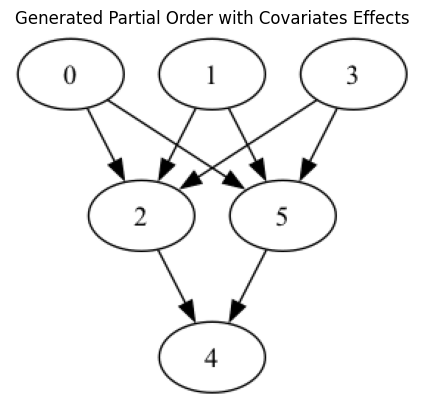

In [5]:

# 6. Generate latent positions for each assessor
# U matrix represents the base latent positions in K-dimensional space
K = StatisticalUtils.rKprior(K_prior) 
U = GenerationUtils.generate_U(n, K, rho_true)
print("\nBase U matrix (latent positions):")
print(U)

# 7. Generate latent positions with covariates effects
# η = U + α1ᵀₖ (adding covariates effects)
eta = StatisticalUtils.transform_U_to_eta(U, alpha)
print("\nAdjusted latent positions (eta):")
print(eta)

print("\nRegression Information:")
print("Design Matrix (X):")
print(X)
print("\nTrue Regression Coefficients (beta):")
print(beta_true)
print("\nCovariatesEffects (alpha = Xβ):")
print(alpha)

# 8. Generate partial order from adjusted latent positions
# First generate the full partial order
h = BasicUtils.generate_partial_order(eta)
# Then compute its transitive reduction to remove redundant edges
h_true = BasicUtils.transitive_reduction(h.copy())
print("\nPartial Order (adjacency matrix):")
print(h_true)

# 9. Print descriptive statistics of the generated partial order
print("\nPartial Order Statistics:")
print(f"Number of items: {n}")
print(f"Number of covariates: {p}")
print(f"Number of direct relationships: {np.sum(h_true)}")
print(f"Number of linear extensions: {BasicUtils.nle(h_true)}")

# 10. Visualize the partial order
POPlot.visualize_partial_order(
    h_true, 
    items,
    title='Generated Partial Order with Covariates Effects'
)


## B) Generate Total Orders with Queue Jump Error

This section demonstrates how to generate total orders from the given partial order while incorporating queue jump errors. The process involves:

1. **Subset Sampling**
   - Given a partial order, sample a subset of items
   - This subset contains the selected items for each ordre 

2. **Queue Jump Error Model**
   - Items are selected from the top of a queue
   - The queue continues to mix rapidly
   - Selection is constrained by the suborder on remaining items
    Before the iᵗʰ entry (yᵢ) is chosen:
    - There are m - i + 1 elements remaining (yᵢ:m)
    - With probability p: yᵢ is chosen randomly (ignoring order constraints)
    - With probability (1-p): yᵢ is the maximal element in a random linear extension

The probability of a sequence y₁:m given poset h and noise parameter p is:

<div style="text-align: center">

pₛ(y₁:m|h, p) = ∏ᵢ₌₁ᵐ⁻¹ q(yᵢ:m|h[yᵢ:m], p)

</div>

where:

<div style="text-align: center">

q(yᵢ:m|h[yᵢ:m], p) = p/(m-j+1) + (1-p)qᵧᵢₘ(yᵢ|h[yᵢ:m])

</div>


In [15]:
## Generate the subsets 
items = list(range(n))
item_to_index = {item: idx for idx, item in enumerate(items)}

subsets = GenerationUtils.generate_subsets(N, n)
print(subsets)
## we generate the queue jump noise total order for each subset


[[1, 3, 4, 5], [0, 1, 3, 5], [1, 3], [0, 1, 2, 3, 5], [0, 1, 3], [0, 1, 2, 3, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4], [0, 1, 2], [0, 3, 5], [0, 1, 2, 3, 4, 5], [0, 2, 3], [0, 1, 2, 3, 4, 5], [0, 1, 3, 4, 5], [2, 3, 4, 5], [0, 2, 4, 5], [0, 2, 4], [0, 2], [0, 2, 3, 4, 5], [0, 2, 5], [1, 5], [1, 2, 3, 5], [0, 1, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [2, 3], [0, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]]


In [16]:
## Genearte the total order 
h_tc=BasicUtils.transitive_closure(h)
noise_beta_prior = config["prior"]["noise_beta_prior"] 
prob_noise = StatisticalUtils.rPprior(noise_beta_prior)
prob_noise_true=prob_noise

total_orders = []
for choice_set in subsets:
    if noise_option == "queue_jump":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_queue_jump(choice_set, items,h_tc, prob_noise)

    elif noise_option == "mallows_noise":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_mallow_noise(choice_set,items, h_tc,  mallow_ua)
    total_orders.append(y_generated)

# Analyze the order distribution
print("\nSampling Statistics:")
print(f"Number of unique total orders: {len(set(map(tuple, total_orders)))}")
print(f"Most common ordering: {max(set(map(tuple, total_orders)), key=total_orders.count)}")



Sampling Statistics:
Number of unique total orders: 27
Most common ordering: (3, 1, 0, 2, 5, 4)


## B) MCMC Simulation for Partial Order Inference

This section implements the Metropolis-Hastings MCMC algorithm to infer the underlying partial order h from observed total orders. We'll analyze both the convergence of the chain and the posterior distribution of the inferred partial order.

### Implementation

In [17]:
num_iterations = config["mcmc"]["num_iterations"]
mcmc_pt = [
    config["mcmc"]["update_probabilities"]["rho"],
    config["mcmc"]["update_probabilities"]["noise"],
    config["mcmc"]["update_probabilities"]["U"],
    config["mcmc"]["update_probabilities"]["beta"],
    config["mcmc"]["update_probabilities"]["K"]
]
dr = config["rho"]["dr"]
drbeta=config["beta"]["drbeta"]

noise_option = config["noise"]["noise_option"]
sigma_mallow = config["noise"]["sigma_mallow"]

noise_beta_prior = config["prior"]["noise_beta_prior"]
mallow_ua = config["prior"]["mallow_ua"]
sigma_beta = config["prior"]["sigma_beta"] 
random_seed = config["random_seed"]

 
mcmc_results = mcmc_partial_order_k(
    total_orders,
    subsets,
    num_iterations,
    X,
    dr,
    drbeta,
    sigma_mallow,
    sigma_beta,
    noise_option,
    mcmc_pt,
    rho_prior, 
    noise_beta_prior,
    mallow_ua,
    K_prior,
    random_seed
)

print("MCMC run complete. Returned keys:")
print(mcmc_results.keys())

Iteration 20000/200000 - Accept Rate: 33.89%
Iteration 40000/200000 - Accept Rate: 34.08%
Iteration 60000/200000 - Accept Rate: 33.77%
Iteration 80000/200000 - Accept Rate: 33.75%
Iteration 100000/200000 - Accept Rate: 33.73%
Iteration 120000/200000 - Accept Rate: 33.77%
Iteration 140000/200000 - Accept Rate: 33.86%
Iteration 160000/200000 - Accept Rate: 33.96%
Iteration 180000/200000 - Accept Rate: 34.05%
Iteration 200000/200000 - Accept Rate: 34.00%

Overall Acceptance Rate after 200000 iterations: 34.00%
MCMC run complete. Returned keys:
dict_keys(['Z_trace', 'h_trace', 'K_trace', 'beta_trace', 'index_to_item', 'item_to_index', 'rho_trace', 'prob_noise_trace', 'mallow_theta_trace', 'proposed_rho_vals', 'proposed_prob_noise_vals', 'proposed_mallow_theta_vals', 'proposed_beta_vals', 'proposed_Zs', 'acceptance_rates', 'acceptance_decisions', 'log_likelihood_currents', 'log_likelihood_primes', 'overall_acceptance_rate', 'update_df'])


### Plot the likelihood of the mcmc 


Excluding 20000 burn-in iterations


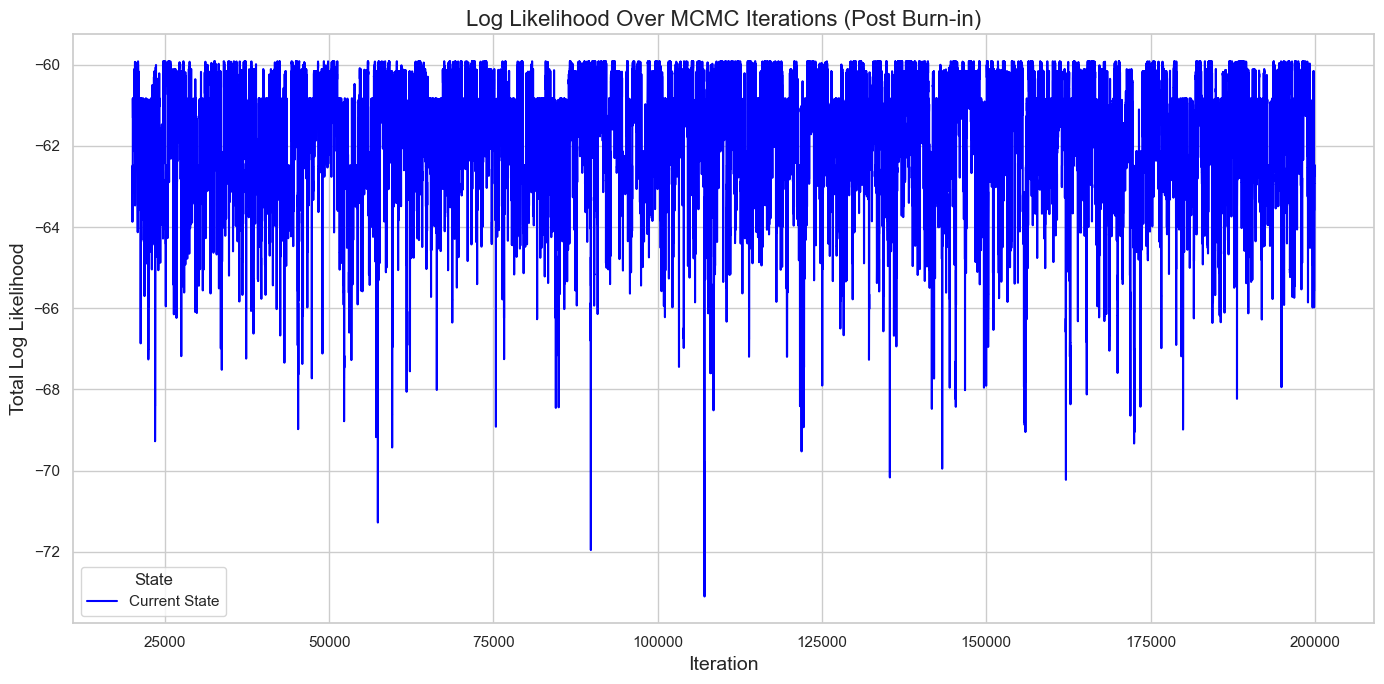

In [9]:
# Get log likelihood values from MCMC results
log_likelihood_currents = mcmc_results.get('log_likelihood_currents', [])
# Create plot
POPlot.plot_log_likelihood(log_likelihood_currents, burn_in=20000)

### The partial order result analysis: 

- Posterior mean of partial orders is computed from remaining iterations
- Threshold of 0.5 is applied to convert posterior probabilities to binary decisions

In [10]:
burn_in = int(20000/ 100)  # Convert to integer (1000 instead of 1000.0)
post_burn_in_trace=mcmc_results['h_trace'][burn_in:]
h_final=np.mean(post_burn_in_trace,axis=0)

threshold=0.5
index_to_item = mcmc_results['index_to_item']
iterations = list(range(1, num_iterations + 1))

h_final_inferred=BasicUtils.transitive_reduction(h_final>=threshold).astype(int)


print("Final adjacency (thresholded):")
print(h_final_inferred)

Final adjacency (thresholded):
[[0 0 1 0 0 1]
 [0 0 1 0 0 1]
 [0 0 0 0 1 0]
 [0 0 1 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]]


Visulise for the h_trace from MCMC, the functions counts the unique partial orders in the h_Trace and also show top N partial orders with counts and percentages.  

Total number of samples in h_trace: 1800



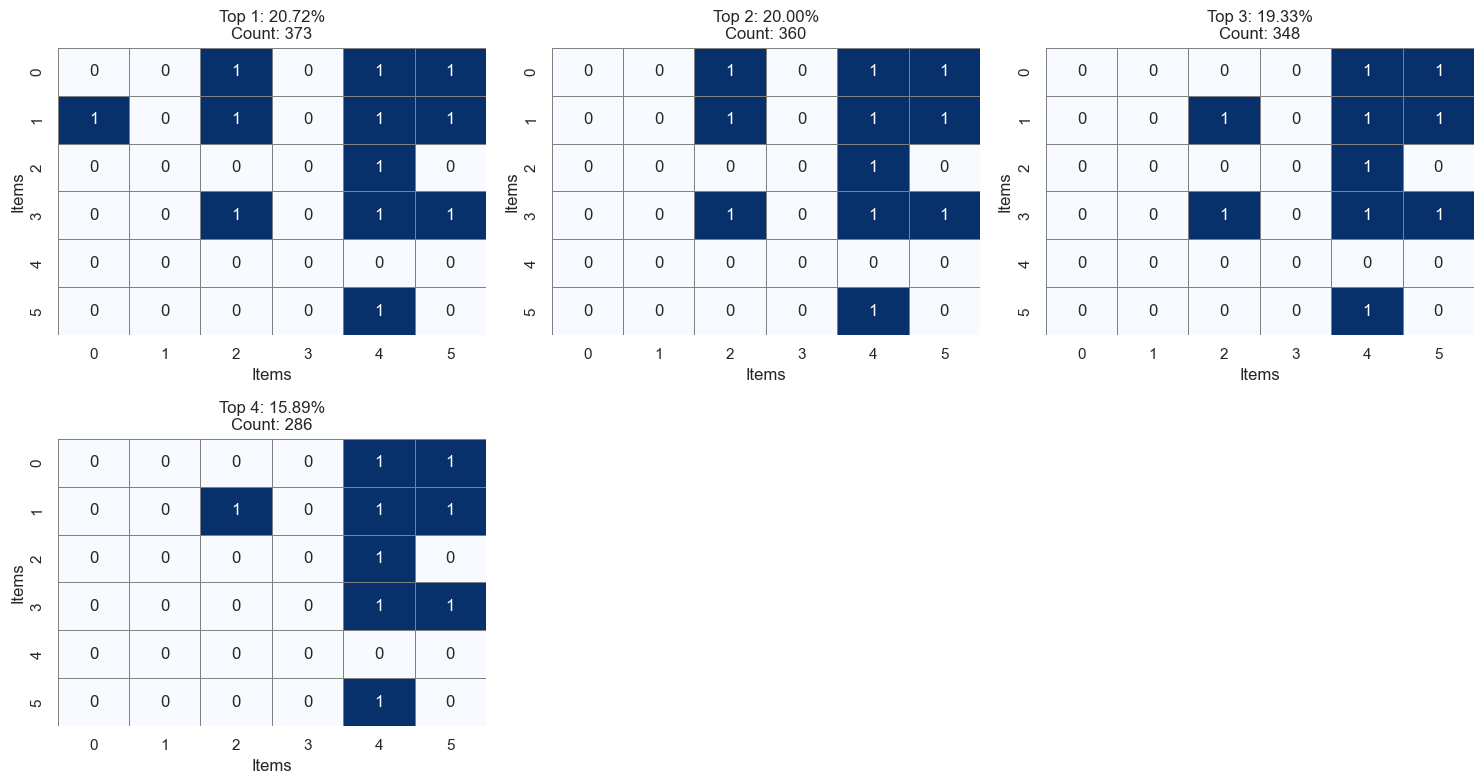

In [11]:
# Analyze partial orders from MCMC results

sorted_unique_orders = StatisticalUtils.count_unique_partial_orders(post_burn_in_trace)       

total_samples = sum(count for _, count in sorted_unique_orders)
print(f"Total number of samples in h_trace: {total_samples}\n")
top_n = 4
top_partial_orders = sorted_unique_orders[:top_n]
top_percentages = [(order, count, (count / total_samples) * 100) for order, count in top_partial_orders]

items = sorted(set(itertools.chain.from_iterable(total_orders)))
n = len(items)
item_labels = items  # ['A', 'B', 'C']
# Plot the top 5 partial orders
POPlot.plot_top_partial_orders(top_percentages, top_n=top_n, item_labels=item_labels)


### Inferred h comparison 
In the end, we want to compare the simulated h and the true h, especially the missing relationship between items.

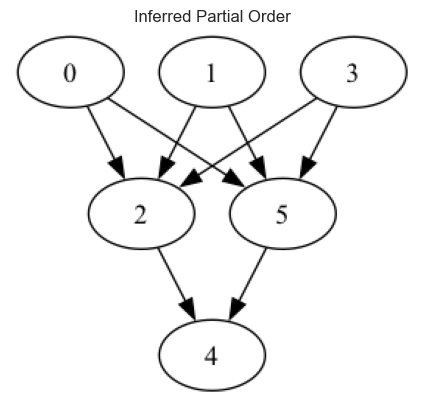

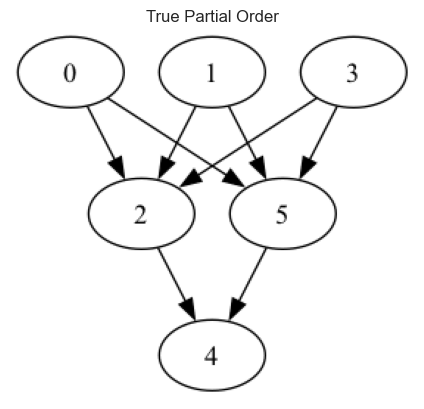


No missing relationships. The inferred partial order matches the true partial order.

No redundant relationships. The inferred partial order is a subset of the true partial order.


In [12]:

missing_relationships = BasicUtils.compute_missing_relationships(h_true, h_final_inferred, index_to_item)
redundant_relationships= BasicUtils.compute_redundant_relationships(h_true, h_final_inferred, index_to_item)

# Plot Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=h_final_inferred,
    Ma_list=items, 
    title='Inferred Partial Order',
)

# Plot True Partial Order and Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=BasicUtils.transitive_reduction(h_true),
    Ma_list=items, 
    title='True Partial Order',
)

if missing_relationships:
    print("\nMissing Relationships (edges present in true PO but absent in inferred PO):")
    for i, j in missing_relationships:
        print(f"{i} < {j}")
else:
    print("\nNo missing relationships. The inferred partial order matches the true partial order.")

if redundant_relationships:
    print("\nRedundant Relationships (edges present in inferred PO but absent in true PO):")
    for i, j in redundant_relationships:
        print(f"{i} < {j}")
else:
    print("\nNo redundant relationships. The inferred partial order is a subset of the true partial order.")

[INFO] Saved MCMC parameter plots to 'mcmc_inferred_result.pdf'


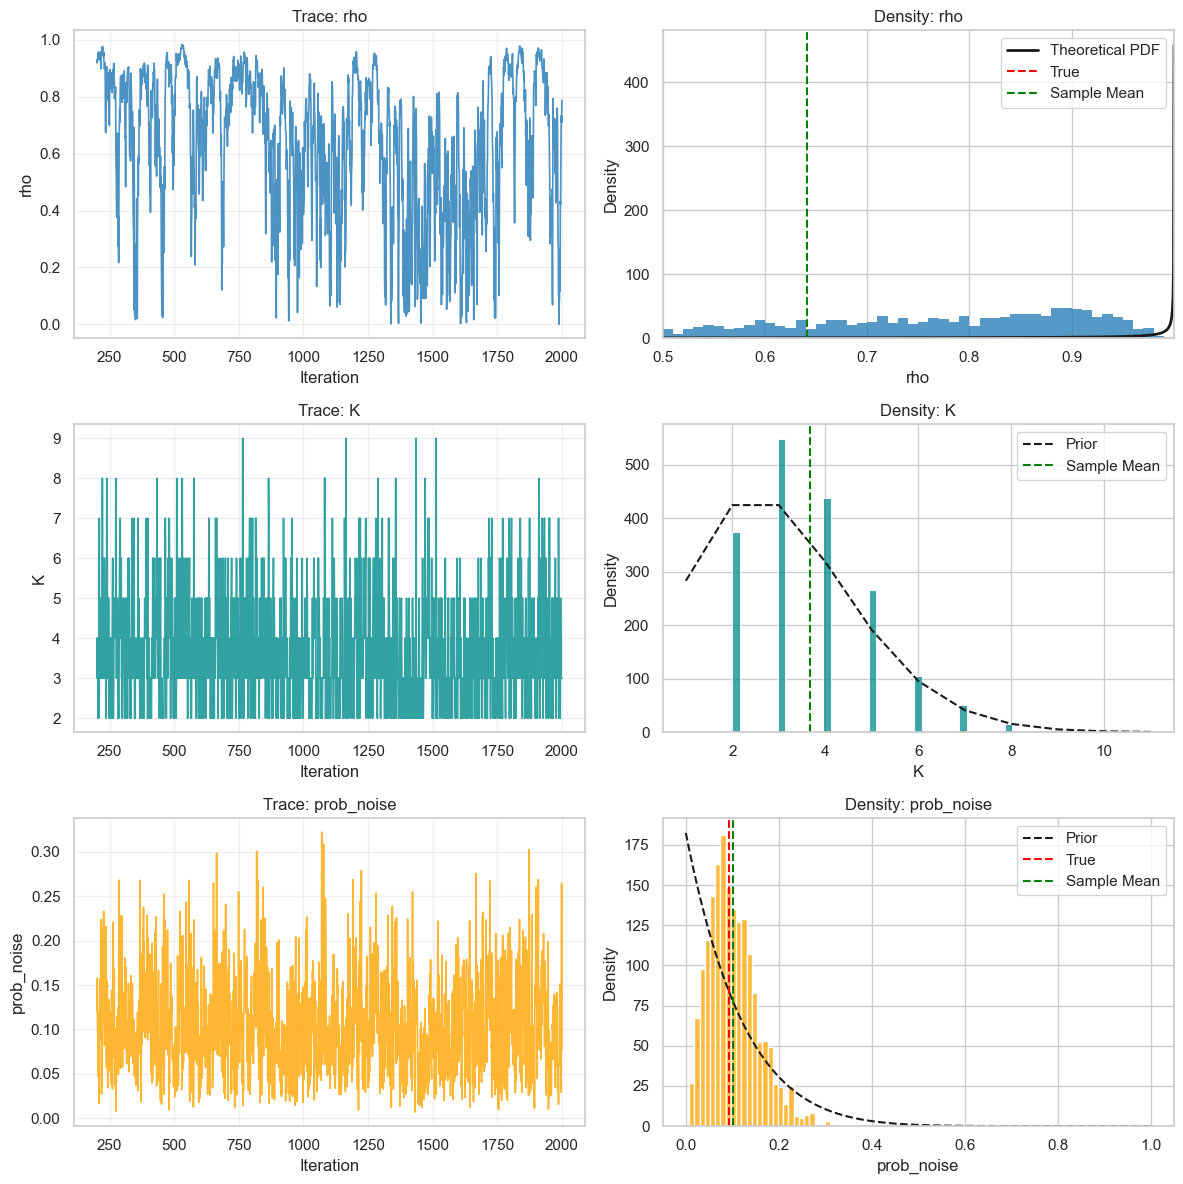

In [13]:
true_param = {
    "rho_true": rho_true,
    "prob_noise_true": prob_noise_true,

}
POPlot.plot_mcmc_inferred_variables(
    mcmc_results,
    true_param,
    config,
    burn_in=burn_in,  # optional
    output_filename="mcmc_inferred_result.pdf"
)

[INFO] Saved beta coefficient 0 plot to './beta_0_plot.pdf'


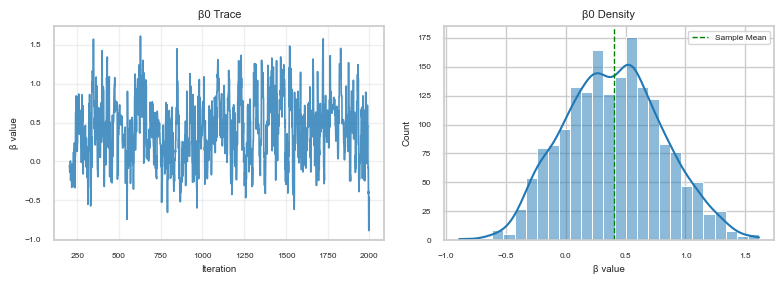

[INFO] Saved beta coefficient 1 plot to './beta_1_plot.pdf'


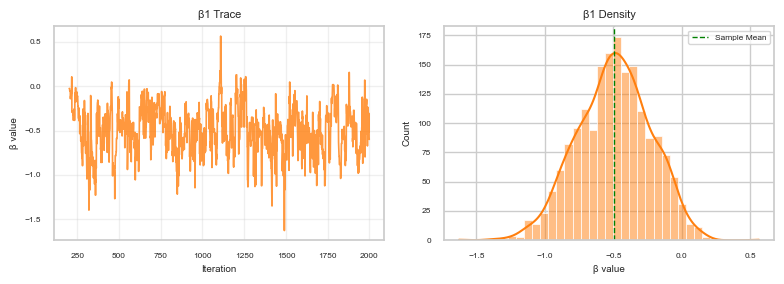

In [14]:
POPlot.plot_beta_parameters(mcmc_results, true_param, config, burn_in=burn_in)